Syntax natürlicher Sprachen, WS 2023/24

# Probeklausur

- **Datum: 16.01.2024**
- **Bearbeitungszeitraum: 11:30-11:45**
- **Abgabetest in Moodle bis 12:00 möglich**


## Übersicht

- [Hinweise zur Bearbeitung](#Hinweise-zur-Bearbeitung)
- [Laden von Paketen](#Laden-von-Paketen)


---

1. [Konstituenten- und Adjunkttests](#1.-Konstituenten--und-Adjunkttests)

---
2. [Konstituentengrammatik](#2.-Konstituentengrammatik)
3. [X-Bar-Struktur](#3.-X-Bar-Struktur)
4. [Parsing-Algorithmen und Rekursionstypen](#4.-Parsing-Algorithmen-und-Rekursionstypen)

---
5. [Dependenzstruktur](#5.-Dependenzstruktur)
6. [Syntaktische Funktion](#6.-Syntaktische-Funktion)
7. [Komplexer Satz](#7.-Komplexer-Satz)

---
8. [Unifikation und Subsumption](#8.-Unifikation-und-Subsumption)
9. [Feature-based-Grammar](#9.-Feature-based-Grammar)


---
10. [Statistisches Parsing](#10.-Statistisches-Parsing)
11. [Datengestuetzte Syntaxanalyse](#11.-Datengestuetzte-Syntaxanalyse)
12. [Chunk-Analysen](#12.-Chunk-Analysen)


---

## Hinweise zur Bearbeitung

### Falls noch nicht geschehen, benennen Sie bitte zunächst die Datei der Probeklausur-Angabe nach folgendem Schema um: 

 #### `Nachname_Vorname_Matrikelnummer.ipynb`
 

--- 

## Hinweise zum Ausfüllen der Codezellen

### Wenn gegeben, führen Sie zunächst die mit `#RUN` markierten Codezellen zu Beginn einer Aufgabe aus (dies ist für eine erfolgreiche Bearbeitung der Aufgabe notwendig).

### Verändern Sie nur die `#TO_DO`-Codezellen (nur gemäß der Angabe in der jeweiligen Aufgabe)!

### Führen Sie `#TO_DO`-Codezellen nach Bearbeitung aus, um das Output ihrer Lösung zu generieren (dieses muss als Teil Ihrer Lösung mit abgespeichert werden); bei aufeinander aufbauenden Aufgaben (`a)`, `b)`usw.) ist zudem  notwendig, dass Sie Ihre Lösung aus der vorangehenden Teilaufgabe ausführen, damit diese in der folgenden zur Verfügung steht.

### Angegebene Inhalte (Grammatikregeln usw.) dürfen nicht auskommentiert oder gelöscht werden, außer dies wird explizit anders erwähnt!


### WICHTIG: Setzen Sie den Status des Notebooks ggf. auf `Trusted`, damit alle angegebenen Outputs korrekt angezeigt werden.

---

## Hinweis zur Bewertung

### *Jede Teilaufgabe (`#TO_DO`-Codezelle) wird mit 2 Punkten bewertet*

---

[zurück zur Übersicht](#Übersicht)


---

## Laden von Paketen

### Führen Sie zu Beginn folgende Codezelle aus.

### Das erfolgreiche Ausführen dieser ist Voraussetzung für die Bearbeitung der folgenden Aufgaben.  

In [4]:
#RUN (Führen Sie diese Code-Zelle aus:)
import nltk
from nltk.tree import Tree
from nltk import FeatStruct
import itertools


from spacy import displacy

def transform_nr_conll(sent_nr):
    sent_list = []
    for line in list(filter(None, sent_nr.split("\n"))):
        line_list = line.split()
        line_list.pop(0)
        line_list.insert(1,"_")
        sent_list.append(" ".join([i for i in line_list[0:]]))

    return "\n".join([i for i in sent_list[0:]])



from nltk import DependencyGraph
from itertools import chain

def _tree_labeled(self, i):
        node = self.get_by_address(i)
        word = node["word"]
        rel = node["rel"]        
        deps = sorted(chain.from_iterable(node["deps"].values()))

        if deps:
            return Tree(word+'('+rel+')', [self._tree_labeled(dep) for dep in deps])
        else:
            return word+'('+rel+')'
        
def tree_labeled(self):
        node = self.root

        word = node["word"]
        rel = node["rel"]
        deps = sorted(chain.from_iterable(node["deps"].values()))
        return Tree(word+'('+rel+')', [self._tree_labeled(dep) for dep in deps])

DependencyGraph._tree_labeled = _tree_labeled
DependencyGraph.tree_labeled = tree_labeled



def displacy_dep_input(sent):
    deps = []
    for dep in sent.split('\n'):
        deps.append(dep.split())

    deps = [x for x in deps if x]

    ex = []
    word_list = []
    arc_list = []

    for index, dep in enumerate(deps):
        word_list.append({"text": dep[0], "tag": ""})
        line = index+1
        head = int(dep[2])
        label = dep[3]
        if head>line:
            start = index
            end = head-1
            direction = "left"
        else:
            start = head-1
            end = index  
            direction = "right"
        if(label.lower() != "root"):
            arc_list.append({"start": start, "end": end, "label": label, "dir": direction})

    ex.append({
        "words": word_list,
        "arcs": arc_list
    })    

    return ex



from nltk.featstruct import Feature, UnificationFailure, FeatStructReader
import itertools
from collections import defaultdict


def check_sanity_constraints(th):
    for type1, type2 in itertools.product(th, th):
        if type1 in th[type2] and type2 in th[type1]:
            if type1 != type2:
                raise ValueError(
                    "The type hierarchy is not antisymmetric! " +
                    "{} subsumes {} and vice versa!".format(
                        type1, type2
                    )
                )


def refl_trans_closure(type_hierarchy):
    # make everything a set
    # and compute reflexive closure
    closure = defaultdict(set)
    for t in type_hierarchy:
        closure[t] = set(type_hierarchy[t])
        closure[t].add(t)

    # compute transitive closure
    still_changes = True
    while still_changes:
        still_changes = False
        for x in closure:
            new_for_x = set()
            for y in closure[x]:
                for z in closure[y]:
                    new_for_x.add(z)
            len_before = len(closure[x])
            closure[x].update(new_for_x)
            still_changes |= len(closure[x]) > len_before

    return closure


class HierarchicalFeature(Feature):
    def __init__(self, name, type_hierarchy, **kwargs):
        super(HierarchicalFeature, self).__init__(name, **kwargs)

        self.hierarchy = refl_trans_closure(type_hierarchy)
        check_sanity_constraints(self.hierarchy)

    def unify_base_values(self, fval1, fval2, bindings):
        candidates = self.hierarchy[fval1].intersection(self.hierarchy[fval2])
        score = {t: 0 for t in candidates}
        for type1, type2 in itertools.product(candidates, candidates):
            if type1 in self.hierarchy[type2]:
                score[type1] += 1

        return min(candidates, key=score.__getitem__, default=UnificationFailure)

---

[zurück zur Übersicht](#Übersicht)


--- 

## 1. Konstituenten- und Adjunkttests

## 1.1 Permutationstest

#### Gegeben sei folgender Satz sowie die Permutationen seiner drei Satzglieder:


In [3]:
#RUN:
sentence = ["das", "ist", "ein Satz"]

permutations = list(itertools.permutations(sentence))
for (i, item) in enumerate(permutations):
    print(i, item)    

0 ('das', 'ist', 'ein Satz')
1 ('das', 'ein Satz', 'ist')
2 ('ist', 'das', 'ein Satz')
3 ('ist', 'ein Satz', 'das')
4 ('ein Satz', 'das', 'ist')
5 ('ein Satz', 'ist', 'das')


### Führen Sie obenstehende Codezelle aus.


### Geben Sie (über den Listenindex) eine Permutation des Satzes an, welche das finite Verb als Konstituente bestätigt.

In [ ]:
#TO_DO:
list(itertools.permutations(sentence))[2]

---

[zurück zur Übersicht](#Übersicht)


---

## 1.2 Adjunkt-Test

#### Gegeben sei folgender Satz, dessen drittes Satzglied den geschehens-Test besteht:


In [7]:
sentence = ["er", "wartet", "im Park"]

sentence[0] + " " + sentence[1] + ", und das geschieht " + sentence[2]

'er wartet, und das geschieht im Park'


### Geben Sie (unter Erhalt der Wohlgeformtheit des Ausgangssatzes) ein alternatives drittes Satzglied an, so dass der geschehens-Test fehlschlägt.


In [8]:
#TO_DO:
sentence = ["er", "wartet", "auf den Sonnenaufgang"]

sentence[0] + " " + sentence[1] + ", und das geschieht " + sentence[2]

'er wartet, und das geschieht auf den Sonnenaufgang'

---

[zurück zur Übersicht](#Übersicht)


---

## 2. Konstituentengrammatik

### Schreiben Sie zu dem folgenden Beispielsatz für temporale syntaktische Ambiguität ein minimale CFG, die die intendierte Struktur des Beispielsatzes erkennt. Testen Sie anschließend Ihre Grammatik (Ausgabe nur der korrekten Analyse).

- ***the old man the boat***
  - `intendierte Struktur:` *the old (man the boat)VP*



In [12]:
#TO_DO:

sentence = "the old man the boat"

grammar = nltk.CFG.fromstring("""
    S -> NP VP
    NP -> DET N
    VP -> V NP

    DET -> "the"
    N -> "old" | "boat"
    V -> "man"
""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    

             S              
     ┌───────┴───┐           
     │           VP         
     │       ┌───┴───┐       
     NP      │       NP     
 ┌───┴───┐   │   ┌───┴───┐   
DET      N   V  DET      N  
 │       │   │   │       │   
the     old man the     boat



---

[zurück zur Übersicht](#Übersicht)


---

## 3. X-Bar-Struktur

#### Gegeben sei folgender Satz und eine entsprechende Grammatik:



In [13]:
sentence = "der Hund jagt den Briefträger"

grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V NP
    NP  -> Det N

    Det -> "der"
    Det -> "den"    
    N   -> "Hund"
    N   -> "Briefträger"
    V   -> "jagt"
""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    

              S                      
     ┌────────┴────┐                  
     │             VP                
     │        ┌────┴───┐              
     NP       │        NP            
 ┌───┴───┐    │    ┌───┴───────┐      
Det      N    V   Det          N     
 │       │    │    │           │      
der     Hund jagt den     Briefträger



### 3a) Erweitern Sie den Satz der Angabe um ein präpositionales Adverbial.


In [26]:
#TO_DO:
sentence = "der Hund jagt den Briefträger auf die Straße"

### 3b) Erweitern Sie die Grammatik um entsprechende lexikalische und syntaktische Regeln für den erweiterten Satz. Verwenden Sie das X-Bar-Schema, so dass eine **rekursive Adjunktion** von Adverbialen an die VP ermöglicht wird.


In [34]:
#TO_DO:
grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V NP
    NP  -> Det N

    Det -> "der"
    Det -> "den"    
    N   -> "Hund"
    N   -> "Briefträger"
    V   -> "jagt"

###########ERGAENZTE REGELN:    
    VP -> VERBAL
    VERBAL -> VERBAL PP
    VERBAL -> V NP
    PP -> P NP

    P -> "auf"
    Det -> "die"
    N -> "Straße"
""")


parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    

                    S                                      
     ┌──────────────┴─────────────┐                         
     │                            VP                       
     │                            │                         
     │                          VERBAL                     
     │              ┌─────────────┴───────────┐             
     │            VERBAL                      PP           
     │        ┌─────┴─────┐               ┌───┴───┐         
     NP       │           NP              │       NP       
 ┌───┴───┐    │     ┌─────┴───────┐       │   ┌───┴────┐    
Det      N    V    Det            N       P  Det       N   
 │       │    │     │             │       │   │        │    
der     Hund jagt  den       Briefträger auf die     Straße



---

[zurück zur Übersicht](#Übersicht)


---

## 4. Parsing-Algorithmen und Rekursionstypen


###  4.1 Geben Sie CFG-Regeln an, die bei einem Top-Down-Parser wegen Ambiguität zu längerer Laufzeit führen können.


In [80]:
#TO_DO:
grammar = nltk.CFG.fromstring("""
    S -> NP VP
    NP -> Det N
    NP -> PROPN
    VP -> VP PP
    VP -> V NP
""")

print(grammar)

Grammar with 5 productions (start state = S)
    S -> NP VP
    NP -> Det N
    NP -> PROPN
    VP -> VP PP
    VP -> V NP


---

[zurück zur Übersicht](#Übersicht)


---

### 4.2 Geben Sie CFG-Regeln an, die eine indirekte Rekursion ermöglichen.

In [31]:
#TO_DO:
grammar = nltk.CFG.fromstring("""
    S -> NP VP
    NP -> Det N
    VP -> V | V SBAR
    SBAR -> COMP S
""")

print(grammar)

Grammar with 5 productions (start state = S)
    S -> NP VP
    NP -> Det N
    VP -> V
    VP -> V SBAR
    SBAR -> COMP S


---

[zurück zur Übersicht](#Übersicht)


---

## 5. Dependenzstruktur

## 5.1 Dependenzgrammatik

### Schreiben Sie zu dem folgenden Beispielsatz für syntaktische Ambiguität eine ungelabelte Dependenzgrammatik gemäß der UD-Dependenzregeln. Testen Sie anschließend Ihre Grammatik (Ausgabe mindestens der beiden möglichen Analysen).


In [37]:
#TO_DO:

sentence = "I shot an elephant in my pajamas"

grammar = nltk.DependencyGrammar.fromstring("""
    'shot' -> 'I' | 'elephant' | 'pajamas'
    'elephant' -> 'an' | 'pajamas'
    'pajamas' -> 'my' | 'in'
""")

parser = nltk.ProjectiveDependencyParser(grammar)
for tree in parser.parse(sentence.split()):
    print(tree, "\n")
    tree.pretty_print(unicodelines=True)

(shot I (elephant an) (pajamas in my)) 

      shot                  
 ┌─────┼────────────┐        
 │  elephant     pajamas    
 │     │      ┌─────┴─────┐  
 I     an     in          my

(shot I (elephant an (pajamas in my))) 

        shot                     
 ┌───────┴──────┐                 
 │           elephant            
 │   ┌──────────┴────────┐        
 │   │                pajamas    
 │   │          ┌────────┴─────┐  
 I   an         in             my



---

[zurück zur Übersicht](#Übersicht)


---

## 5.2 Übergangsbasierter Shift-Reduce-Dependency-Parser

#### Betrachten Sie folgende Dependenzanalyse, die die Reihenfolge der Durchführung der `REDUCE`-Übergänge mit einem Shift-Reduce-Dependency-Parser angibt:

In [38]:
sent_nr = """
1 ich 2 LEFTARC-1
2 glaube 0 ROOT
3 es 2 RIGHTARC-2
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

#### Gegeben sei nun folgender Dependenzgraph:

In [39]:
sent_nr = """
1 a 0 ROOT
2 b 1 RIGHTARC-?
3 c 4 LEFTARC-?
4 d 2 RIGHTARC-?
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

### Geben Sie dem Beispiel entsprechend eine deutschen Satz an, der diese Dependenzstrukturanalyse erfüllt; geben Sie außerdem die Reihenfolge der Durchführung der `REDUCE`-Übergänge mit einem Shift-Reduce-Dependency-Parser an.

In [42]:
#TO_DO:
sent_nr = """
1 Siehe 0 ROOT
2 da 1 RIGHTARC-3
3 ein 4 LEFTARC-1
4 Auto 2 RIGHTARC-2
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

---

[zurück zur Übersicht](#Übersicht)


---

## 6. Syntaktische Funktion

### Analysieren Sie die Dependenzbeziehungen des folgenden Satzes im UD-Schema: 

*der Hund jagt den Briefträger um die Stadt*



In [45]:
#TO_DO:
sent_nr = """
1 der 2 det
2 Hund 3 nsubj
3 jagt 0 ROOT
4 den 5 det
5 Briefträger 3 obj
6 um 8 case
7 die 8 det 
8 Stadt 3 obl
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

               jagt(ROOT)                                
     ┌─────────────┼──────────────────────┐               
Hund(nsubj) Briefträger(obj)          Stadt(obl)         
     │             │            ┌─────────┴─────────┐     
  der(det)      den(det)     um(case)            die(det)



--- 

[zurück zur Übersicht](#Übersicht)


---

## 7. Komplexer Satz

#### Gegeben sei folgender Satz mit transitivem Verb und eine entsprechende Grammatik:

In [46]:
sentence = "der Briefträger schreibt einen Brief"

grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V NP
    NP  -> Det N
    NP  -> Pron

    Det -> "der"
    Det -> "den"    
    N   -> "Hund"
    N   -> "Briefträger"
    V   -> "jagt"
    Det -> "einen"    
    N   -> "Brief"
    V   -> "schreibt"    
""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    

                       S                    
     ┌─────────────────┴───────┐             
     │                         VP           
     │                 ┌───────┴────┐        
     NP                │            NP      
 ┌───┴───────┐         │       ┌────┴────┐   
Det          N         V      Det        N  
 │           │         │       │         │   
der     Briefträger schreibt einen     Brief



### 8a) Ändern Sie den Satz ab, so dass er einen Objekt-Komplementsatz enthält. (Satzzeichen können ausgelassen werden.)

In [5]:
#TO_DO:
sentence = "der Briefträger schreibt dass er Hunde mag"

### 8b) Erweitern Sie die Grammatik um entsprechende lexikalische und syntaktische Regeln für Ihren Satz aus 8a.


- Verwenden Sie nur `SBAR` und `Comp` als neue Nonterminale
- X-Bar-Schema ist nicht notwendig (orientieren Sie sich an den Penn-Treebank-Regeln für komplexe Sätze)

##### Beachten Sie die invertierte Wortstellung im Nebensatz (Verbendstellung).


In [6]:
#TO_DO:
grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V NP
    NP  -> Det N
    NP  -> Pron

    Det -> "der"
    Det -> "den"    
    N   -> "Hund"
    N   -> "Briefträger"
    V   -> "jagt"
    Det -> "einen"    
    N   -> "Brief"
    V   -> "schreibt"

###########ERGAENZTE REGELN:    
    VP -> V SBAR
    SBAR -> Comp S
    VP -> NP V
    NP -> N

    Comp -> "dass"
    Pron -> "er"
    N -> "Hunde"
    V -> "mag"
""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    

                              S                          
     ┌────────────────────────┴────┐                      
     │                             VP                    
     │                 ┌───────────┴────┐                 
     │                 │               SBAR              
     │                 │      ┌─────────┴─────┐           
     │                 │      │               S          
     │                 │      │    ┌──────────┴────┐      
     │                 │      │    │               VP    
     │                 │      │    │          ┌────┴───┐  
     NP                │      │    NP         NP       │ 
 ┌───┴───────┐         │      │    │          │        │  
Det          N         V     Comp Pron        N        V 
 │           │         │      │    │          │        │  
der     Briefträger schreibt dass  er       Hunde     mag



### 8c) Erweitern Sie nun Ihre Grammatik aus 8b) um Merkmale, um eine wortstellungsbezogene Überproduktion im Nebensatz mit der alten VP-Regel für den Hauptsatz zu verhindern.

- Nebensatz: Verbendstellung
- Hauptsatz: V2-Stelllung


In [9]:
#TO_DO:

#NEGATIVBEISPIEL:
neg_sentence = "der Briefträger schreibt dass er mag Hunde"

gramstring = r"""
% start S

########GRAMMATIK AUS 8b):
    S[SBAR=?x]   -> NP VP[SBAR=?x]
    VP[-SBAR]  -> V NP
    NP  -> Det N
    NP  -> Pron

    Det -> "der"
    Det -> "den"    
    N   -> "Hund"
    N   -> "Briefträger"
    V   -> "jagt"
    Det -> "einen"    
    N   -> "Brief"
    V   -> "schreibt"

###########ERGAENZTE REGELN:    
    VP -> V SBAR
    SBAR -> Comp S[+SBAR]
    VP[+SBAR] -> NP V
    NP -> N

    Comp -> "dass"
    N -> "er" | "Hunde"
    V -> "mag"
"""

grammar = nltk.grammar.FeatureGrammar.fromstring(gramstring)
parser = nltk.parse.FeatureChartParser(grammar,trace=0)

for tree in parser.parse(neg_sentence.split()):
    tree = Tree.fromstring(str(tree).replace(", ",","))
    #tree.pretty_print(unicodelines=True)
    display(tree)

---

[zurück zur Übersicht](#Übersicht)


---

## 8. Unifikation und Subsumption



## 8.1 Unifikation von Merkmalsstrukturen

#### Gegeben seien folgende (unifizierende) Merkmalsstrukturen:

In [53]:
f1 = FeatStruct("[CASE=nom,AGR=[GEN=mask, PERS=1]]")
f2 = FeatStruct("[]")
print(f1.unify(f2))

[ AGR  = [ GEN  = 'mask' ] ]
[        [ PERS = 1      ] ]
[                          ]
[ CASE = 'nom'             ]


### Geben Sie eine alternative Merkmalsstruktur `f2` an, die ***nicht*** mit `f1`unifiziert. 

In [54]:
#TO_DO:
f1 = FeatStruct("[CASE=nom,AGR=[GEN=mask, PERS=1]]")
f2 = FeatStruct("[CASE=akk]")
print(f1.unify(f2))

None


---

[zurück zur Übersicht](#Übersicht)


---

## 8.2 Unifikation mit Typen

#### Gegeben sei folgende Typhierarchie:

$$\bot \sqsubseteq \text{Genitiv}$$
$$\bot \sqsubseteq \text{nicht-Genitiv}$$
$$\text{nicht-Genitiv} \sqsubseteq \text{Nominativ-Akkusativ}$$
$$\text{nicht-Genitiv} \sqsubseteq \text{Dativ}$$
$$\text{Nominativ-Akkusativ} \sqsubseteq \text{Nominativ}$$
$$\text{Nominativ-Akkusativ} \sqsubseteq \text{Akkusativ}$$

####  Sie wird (mit abgekürzten Typnamen) durch das `*CASE*`-Feature implementiert:

In [55]:
#RUN:
type_hierarchy = {
    "nichtGen": ["NomAkk", "Dat"],
    "NomAkk": ["Nom", "Akk"],
    "Dat": [],
    "Akk": [],
    "Gen": [],
    "Nom": []
}
CASE = HierarchicalFeature("CASE", type_hierarchy)
reader = FeatStructReader(features=(CASE,))

### Führen Sie obenstehende Codezelle aus, um die Typhierarchie zu laden.

### Geben Sie eine (nicht-leere) Merkmalstruktur `f2` an, sodass gilt:

`f2` subsumiert `f1`.

In [56]:
#TO_DO:
f1 = reader.fromstring("[*CASE*=NomAkk]")
f2 = reader.fromstring("[*CASE*=nichtGen]")
f2.subsumes(f1)

True

---

[zurück zur Übersicht](#Übersicht)


---

## 9. Feature-based-Grammar

### 9a) Erweitern Sie folgende Angabe um einen Satz mit intransitivem Verb sowie die Grammatik um entsprechende syntaktische sowie lexikalische Regeln.

In [62]:
#TO_DO:

sentence = "der Briefträger wartet"

grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V NP
    NP  -> Det N

    Det -> "der"
    Det -> "den"    
    N   -> "Brief"
    N   -> "Briefträger"
    V   -> "beantwortet"

###########ERGAENZTE REGELN:    
    VP -> V
    V -> "wartet"
""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    

             S            
     ┌───────┴────────┐    
     NP               VP  
 ┌───┴───────┐        │    
Det          N        V   
 │           │        │    
der     Briefträger wartet



### 9b) Geben Sie einen nach den Regeln der deutschen Grammatik nicht-wohlgeformten Satz an, der fälschlicherweise von der oben angegebenen Grammatik erkannt wird, obwohl er gegen ein *Subkategorisierungs-Constraint* verstößt.


In [66]:
#TO_DO:
neg_sentence = "der Briefträger wartet den Brief"

### 9c) Erweitern Sie Ihre Grammatik aus a) um Merkmale, um die Überproduktion aus b) zu verhindern.


In [67]:
#TO_DO:
gramstring = r"""
% start S

########GRAMMATIK AUS 9a):
    S   -> NP VP
    VP  -> V[SUBCAT=0] NP
    NP  -> Det N

    Det -> "der"
    Det -> "den"    
    N   -> "Brief"
    N   -> "Briefträger"
    V[SUBCAT=0]   -> "beantwortet"

###########ERGAENZTE REGELN:    
    VP -> V[SUBCAT=1]
    V[SUBCAT=1] -> "wartet"
"""

grammar = nltk.grammar.FeatureGrammar.fromstring(gramstring)
parser = nltk.parse.FeatureChartParser(grammar,trace=0)

#NEGATIVBEISPIEL (neg_sentence aus 9b):
for tree in parser.parse(neg_sentence.split()):
    tree = Tree.fromstring(str(tree).replace(", ",","))
    #tree.pretty_print(unicodelines=True)
    display(tree)

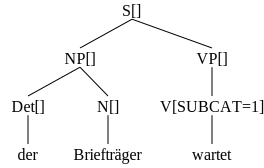

In [68]:
#TEST POSITIVBEISPIEL (sentence aus 9a):
for tree in parser.parse(sentence.split()):
    tree = Tree.fromstring(str(tree).replace(", ",","))
    #tree.pretty_print(unicodelines=True)
    display(tree)    

---


[zurück zur Übersicht](#Übersicht)


---
## 10. Statistisches Parsing


#### Gegeben sei folgende Mini-Treebank mit PP-Attachment-Sätzen:


In [69]:
treestrings = [
"(S (NP Ich) (VP (V gehe)) (PP auf dem Weg))",
"(S (NP Ich) (VP (V steige) (PP auf den Berg)))",
"(S (NP Ich) (VP (V klettere) (PP auf den Berg)))",
"(S (NP Ich) (VP (V laufe)) (PP auf dem Weg))",
"(S (NP Ich) (VP (V renne)) (PP auf dem Weg))",
]

trees = []
for treestring in treestrings:
    trees.append(Tree.fromstring(treestring))
    

for tree in trees:
    tree.pretty_print(unicodelines=True)

          S         
 ┌───┬────┴───┐      
 │   VP       │     
 │   │        │      
 NP  V        PP    
 │   │    ┌───┼───┐  
Ich gehe auf dem Weg

            S              
 ┌──────────┴───┐           
 │              VP         
 │    ┌─────────┴───┐       
 NP   V             PP     
 │    │     ┌───────┼───┐   
Ich steige auf     den Berg

              S              
 ┌────────────┴───┐           
 │                VP         
 │     ┌──────────┴───┐       
 NP    V              PP     
 │     │      ┌───────┼───┐   
Ich klettere auf     den Berg

           S         
 ┌────┬────┴───┐      
 │    VP       │     
 │    │        │      
 NP   V        PP    
 │    │    ┌───┼───┐  
Ich laufe auf dem Weg

           S         
 ┌────┬────┴───┐      
 │    VP       │     
 │    │        │      
 NP   V        PP    
 │    │    ┌───┼───┐  
Ich renne auf dem Weg



### Passen Sie diese Mini-Treebank durch Auskommentieren einer minimalen Anzahl an Sätzen so an, dass die daraus induzierte Grammatik das VP-Attachment (Subkategorisierung nach PP-Komplement statt Satz-Adjunkt) bevorzugt.


In [72]:
#TO_DO:
treestrings = [
#"(S (NP Ich) (VP (V gehe)) (PP auf dem Weg))",
"(S (NP Ich) (VP (V steige) (PP auf den Berg)))",
"(S (NP Ich) (VP (V klettere) (PP auf den Berg)))",
"(S (NP Ich) (VP (V laufe)) (PP auf dem Weg))",
"(S (NP Ich) (VP (V renne)) (PP auf dem Weg))",
]

trees = []
for treestring in treestrings:
    trees.append(Tree.fromstring(treestring))

##print trees in treebank:
#for tree in trees:
#    tree.pretty_print(unicodelines=True)
    
    
#grammar induction:    
productions = []
S = nltk.Nonterminal('S')

for tree in trees:
    productions += tree.productions()

grammar = nltk.induce_pcfg(S, productions)
for production in grammar.productions():
    print(production)    
    
#parse trees with grammar:    
parser = nltk.ViterbiParser(grammar)
     
for tree in trees:
    for parse in parser.parse(tree.leaves()): 
        print(parse)
        parse.pretty_print(unicodelines=True) 

S -> NP VP [0.5]
NP -> 'Ich' [1.0]
VP -> V PP [0.5]
V -> 'steige' [0.25]
PP -> 'auf' 'den' 'Berg' [0.5]
V -> 'klettere' [0.25]
S -> NP VP PP [0.5]
VP -> V [0.5]
V -> 'laufe' [0.25]
PP -> 'auf' 'dem' 'Weg' [0.5]
V -> 'renne' [0.25]
(S (NP Ich) (VP (V steige) (PP auf den Berg))) (p=0.03125)
            S              
 ┌──────────┴───┐           
 │              VP         
 │    ┌─────────┴───┐       
 NP   V             PP     
 │    │     ┌───────┼───┐   
Ich steige auf     den Berg

(S (NP Ich) (VP (V klettere) (PP auf den Berg))) (p=0.03125)
              S              
 ┌────────────┴───┐           
 │                VP         
 │     ┌──────────┴───┐       
 NP    V              PP     
 │     │      ┌───────┼───┐   
Ich klettere auf     den Berg

(S (NP Ich) (VP (V laufe) (PP auf dem Weg))) (p=0.03125)
           S             
 ┌─────────┴───┐          
 │             VP        
 │    ┌────────┴───┐      
 NP   V            PP    
 │    │    ┌───────┼───┐  
Ich laufe auf     d

---

[zurück zur Übersicht](#Übersicht)


---

## 11. Datengestuetzte Syntaxanalyse
   


## 11.1 Lexikalisierte CFG (mit Merkmalen)

#### Gegeben sei folgende FCFG mit nur teilweise durchgeführter Kopfannotation (über ein `HEAD`-Merkmal):

In [73]:
sentence = "der Hund jagt den Briefträger"

gramstring = r"""
% start S
    S[]   -> NP[] VP[]
    VP[]  -> V[] NP[]
    NP[HEAD=?n]  -> Det[] N[HEAD=?n]

    Det[] -> "der"
    Det[] -> "den"    
    N[HEAD="Hund"]   -> "Hund"
    N[]   -> "Briefträger"
    V[]   -> "jagt"    
"""

grammar = nltk.grammar.FeatureGrammar.fromstring(gramstring)
parser = nltk.parse.FeatureChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    print(tree)
    tree = Tree.fromstring(str(tree).replace(", ",","))
    tree.pretty_print(unicodelines=True)
    #display(tree)

(S[]
  (NP[HEAD='Hund'] (Det[] der) (N[HEAD='Hund'] Hund))
  (VP[] (V[] jagt) (NP[HEAD=?n] (Det[] den) (N[] Briefträger))))
                                     S[]                               
             ┌────────────────────────┴─────┐                           
             │                             VP[]                        
             │                        ┌─────┴────────┐                  
      NP[HEAD='Hund']                 │         NP[HEAD=?n]            
  ┌──────────┴──────────────┐         │     ┌────────┴───────────┐      
Det[]                 N[HEAD='Hund'] V[]  Det[]                 N[]    
  │                         │         │     │                    │      
 der                       Hund      jagt  den              Briefträger



### Vervollständigen Sie die Kopfannotation.


In [75]:
#TO_DO:
sentence = "der Hund jagt den Briefträger"

gramstring = r"""
% start S
    S[HEAD=?v]   -> NP[] VP[HEAD=?v]
    VP[HEAD=?v]  -> V[HEAD=?v] NP[]
    NP[HEAD=?n]  -> Det[] N[HEAD=?n]

    Det[HEAD="der"] -> "der"
    Det[HEAD="den"] -> "den"    
    N[HEAD="Hund"]   -> "Hund"
    N[HEAD="Briefträger"]   -> "Briefträger"
    V[HEAD="jagt"]   -> "jagt"    
"""

grammar = nltk.grammar.FeatureGrammar.fromstring(gramstring)
parser = nltk.parse.FeatureChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    print(tree)
    tree = Tree.fromstring(str(tree).replace(", ",","))
    tree.pretty_print(unicodelines=True)
    #display(tree)

(S[HEAD='jagt']
  (NP[HEAD='Hund'] (Det[HEAD='der'] der) (N[HEAD='Hund'] Hund))
  (VP[HEAD='jagt']
    (V[HEAD='jagt'] jagt)
    (NP[HEAD='Briefträger']
      (Det[HEAD='den'] den)
      (N[HEAD='Briefträger'] Briefträger))))
                                               S[HEAD='jagt']                                                  
                       ┌─────────────────────────────┴───────────────┐                                          
                       │                                      VP[HEAD='jagt']                                  
                       │                             ┌───────────────┴───────────────┐                          
                NP[HEAD='Hund']                      │                        NP[HEAD='Brieftr                 
                       │                             │                             äger']                      
       ┌───────────────┴──────────────┐              │               ┌───────────────┴──────────────

---

[zurück zur Übersicht](#Übersicht)



---


## 11.2 Parent Annotation (mit Symbolerweiterung)

#### Gegeben sei folgende CFG für einen Satz mit transitivem Verb mit unvollständiger *Parent Annotation*:

In [76]:
sentence = "der Hund jagt den Briefträger"

grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V NP
    NP  -> Det^NP N

    Det^NP -> "der"
    Det^NP -> "den"    
    N   -> "Hund"
    N   -> "Briefträger"
    V   -> "jagt"  
""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    

                 S                         
        ┌────────┴─────┐                    
        │              VP                  
        │        ┌─────┴─────┐              
        NP       │           NP            
  ┌─────┴───┐    │     ┌─────┴───────┐      
Det^NP      N    V   Det^NP          N     
  │         │    │     │             │      
 der       Hund jagt  den       Briefträger



### Vervollständigen Sie über Symbolerweiterung (mit `^` als Trennerzeichen) in der CFG die *Parent Annotation*, wie sie durch die Regelanwendungen im Syntaxbaum der Angabe impliziert ist.

In [77]:
#TO_DO:
sentence = "der Hund jagt den Briefträger"

grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V NP
    NP  -> Det^NP N

    Det^NP -> "der"
    Det^NP -> "den"    
    N   -> "Hund"
    N   -> "Briefträger"
    V   -> "jagt"

###########ERGAENZTE REGELN:    
  S -> NP^S VP^S
  VP^S -> V^VP NP^VP
  NP^S -> Det^NP N^NP
  NP^VP -> Det^NP N^NP

  N^NP -> "Hund" | "Briefträger"
  V^VP -> "jagt"
""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    

                  S                           
        ┌─────────┴─────┐                      
        │              VP^S                   
        │         ┌─────┴──────┐               
       NP^S       │          NP^VP            
  ┌─────┴────┐    │     ┌──────┴────────┐      
Det^NP      N^NP V^VP Det^NP           N^NP   
  │          │    │     │               │      
 der        Hund jagt  den         Briefträger

                 S                         
        ┌────────┴─────┐                    
        │              VP                  
        │        ┌─────┴─────┐              
        NP       │           NP            
  ┌─────┴───┐    │     ┌─────┴───────┐      
Det^NP      N    V   Det^NP          N     
  │         │    │     │             │      
 der       Hund jagt  den       Briefträger



---

[zurück zur Übersicht](#Übersicht)


---

## 12. Chunk-Analysen

### Vervollständigen Sie den die folgende *IOB-Tag-Sequenz* einer NP-Chunk-Analyse erfüllenden deutschen Satz.

#### (Beachten Sie auch die gegebenen Satzzeichen bzgl. möglicher Satztypen und entsprechender Worstellung.)


In [78]:
#TO_DO:
iob_list = [
("B-NP", "Das"),
("I-NP", "neue"),
("I-NP", "Jahr"),
("O", "bringt"), 
("B-NP", "mir"),
("B-NP", "viel"),
("I-NP", "Freude"),
("O", ".")
]

print(iob_list)

[('B-NP', 'Das'), ('I-NP', 'neue'), ('I-NP', 'Jahr'), ('O', 'bringt'), ('B-NP', 'mir'), ('B-NP', 'viel'), ('I-NP', 'Freude'), ('O', '.')]


---

[zurück zur Übersicht](#Übersicht)
